<h1><center>Next Word Prediction Using LSTM and GRU</center></h1>

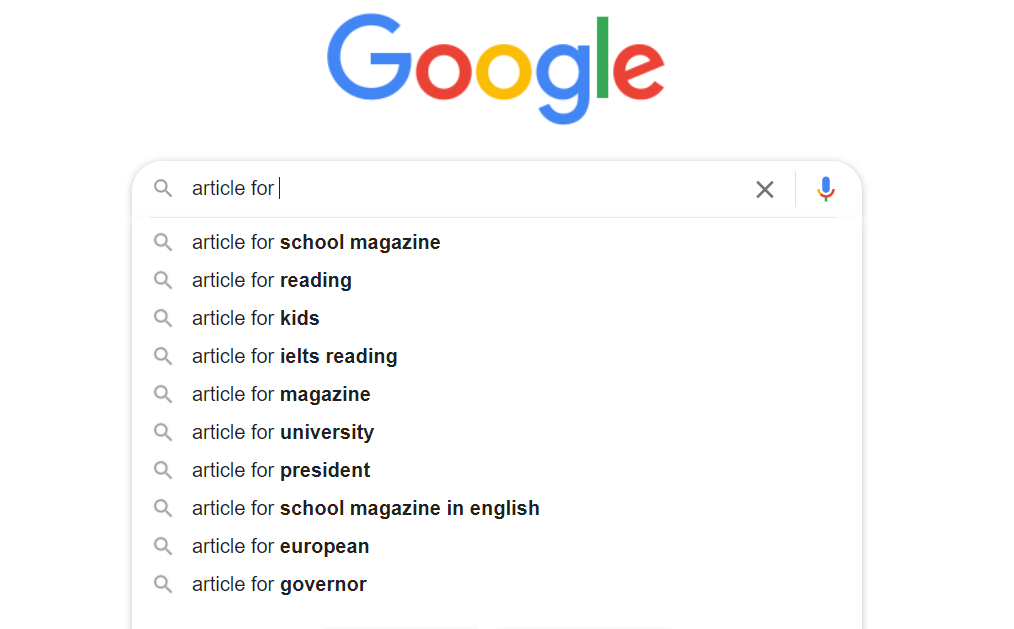

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional,GRU

## Loading the data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d dorianlazar/medium-articles-dataset

Dataset URL: https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset
License(s): CC0-1.0
 99% 1.32G/1.33G [00:16<00:00, 75.5MB/s]
100% 1.33G/1.33G [00:16<00:00, 87.4MB/s]


In [3]:
import zipfile
ref = zipfile.ZipFile('/content/medium-articles-dataset.zip')
ref.extractall('/content')
ref.close()


## Dataset Information

**This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:**

1. Towards Data Science
2. UX Collective
3. The Startup
4. The Writing Cooperative
5. Data Driven Investor
6. Better Humans
7. Better Marketing



In [4]:
data = pd.read_csv('medium_data.csv')

In [5]:
print('Number of Records : ',data.shape[0])
print('Number of Features : ',data.shape[1])

Number of Records :  6508
Number of Features :  10


In [6]:
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


**Here, We have total 6508 records and 10 feilds but for our task we are going to consider only 'title feature .So lets begin our analysis.**

## Overview of titles of various articles

In [7]:
data['title'].head()

0    A Beginner’s Guide to Word Embedding with Gens...
1    Hands-on Graph Neural Networks with PyTorch & ...
2                         How to Use ggplot2 in Python
3    Databricks: How to Save Files in CSV on Your L...
4    A Step-by-Step Implementation of Gradient Desc...
Name: title, dtype: object

## Data Preprocessing

**Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.**

In [8]:
data['title']=data['title'].apply(lambda x:x.replace('\xa0',' '))
data['title']=data['title'].apply(lambda x: x.replace('\u200a',' '))

## Tokenization

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['title'])

In [10]:
tokenizer.word_index

{'to': 1,
 'the': 2,
 'strong': 3,
 'a': 4,
 'of': 5,
 'how': 6,
 'and': 7,
 'in': 8,
 'your': 9,
 'markup': 10,
 'for': 11,
 'you': 12,
 'with': 13,
 'is': 14,
 '—': 15,
 'data': 16,
 'why': 17,
 'class': 18,
 'h3': 19,
 'i': 20,
 'what': 21,
 'on': 22,
 'learning': 23,
 'from': 24,
 'an': 25,
 'be': 26,
 'my': 27,
 'writing': 28,
 'are': 29,
 'it': 30,
 'can': 31,
 'using': 32,
 'design': 33,
 'machine': 34,
 'ux': 35,
 'about': 36,
 'do': 37,
 'not': 38,
 'python': 39,
 'ai': 40,
 'life': 41,
 'that': 42,
 'when': 43,
 'should': 44,
 'we': 45,
 '5': 46,
 'science': 47,
 'make': 48,
 'time': 49,
 'need': 50,
 'as': 51,
 '3': 52,
 'more': 53,
 'at': 54,
 'business': 55,
 'or': 56,
 'part': 57,
 'have': 58,
 'work': 59,
 'new': 60,
 'don’t': 61,
 'up': 62,
 'by': 63,
 'write': 64,
 'get': 65,
 'use': 66,
 'guide': 67,
 'will': 68,
 'marketing': 69,
 '1': 70,
 'ways': 71,
 'deep': 72,
 'best': 73,
 'analysis': 74,
 'first': 75,
 '2019': 76,
 'product': 77,
 'better': 78,
 'things': 79,


In [13]:
print('Total Number of words in our data is :',len(tokenizer.word_index))

Total Number of words in our data is : 8236


In [11]:
title_list = []
for sentence in data['title']:
    title_list.append(sentence)

In [12]:
title_list[:5]

['A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model',
 'Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric',
 'How to Use ggplot2 in Python',
 'Databricks: How to Save Files in CSV on Your Local Computer',
 'A Step-by-Step Implementation of Gradient Descent and Backpropagation']

## Creating Input Sequences

In [14]:
input_sequence = []
for sent in title_list:
    tokenized_sentence = tokenizer.texts_to_sequences([sent])[0]
    for i in range(1,len(tokenized_sentence)):
        input_sequence.append(tokenized_sentence[:i+1])

print('Total Input Sequence : ',len(input_sequence))

Total Input Sequence :  48461


In [15]:
input_sequence[:5]

[[4, 675],
 [4, 675, 67],
 [4, 675, 67, 1],
 [4, 675, 67, 1, 451],
 [4, 675, 67, 1, 451, 1517]]

In [16]:
max_len = max([len(x) for x in input_sequence])
print('Maximum length of sentence in our data is : ',max_len)

Maximum length of sentence in our data is :  40


## Padding

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_input_sequences = pad_sequences(input_sequence,maxlen = max_len,padding = 'pre')
padded_input_sequences

array([[  0,   0,   0, ...,   0,   4, 675],
       [  0,   0,   0, ...,   4, 675,  67],
       [  0,   0,   0, ..., 675,  67,   1],
       ...,
       [  0,   0,   0, ...,   4,  84,  55],
       [  0,   0,   0, ...,  84,  55, 729],
       [  0,   0,   0, ...,  55, 729, 549]], dtype=int32)

## Preparing the features and Labels

**Here, we consider last element of all sequences as a label.Then, We need to perform one-hot encoding on labels corresponding to total_words which is 8236.**

In [18]:
X = padded_input_sequences[:,:-1]
X

array([[  0,   0,   0, ...,   0,   0,   4],
       [  0,   0,   0, ...,   0,   4, 675],
       [  0,   0,   0, ...,   4, 675,  67],
       ...,
       [  0,   0,   0, ...,  64,   4,  84],
       [  0,   0,   0, ...,   4,  84,  55],
       [  0,   0,   0, ...,  84,  55, 729]], dtype=int32)

In [19]:
y = padded_input_sequences[:,-1]
y

array([675,  67,   1, ...,  55, 729, 549], dtype=int32)

In [20]:
print('Shape of X: ',X.shape)

Shape of X:  (48461, 39)


In [21]:
print('Shape of y :',y.shape)

Shape of y : (48461,)


## Applying One-Hot-Encoding on Label

In [22]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y,num_classes = 8237)


**Here we are considering the num_classes as total_words + 1,the reason behind it is the word_index starts with 1 so here we are doing one hot encoding the index starts with 0 so we need to add 1 here to apply it on all the data**

In [23]:
y.shape

(48461, 8237)

## LSTM Neural Network

**1. Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.**

**2. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!**

**3. All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.**

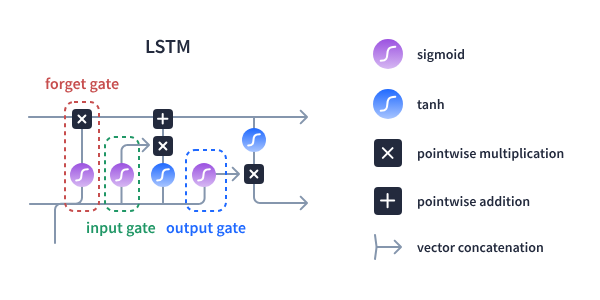

## LSTM Neural Network Model Training

In [24]:
model = Sequential()
model.add(Embedding(8237,300,input_length = 39))
model.add(LSTM(150))
model.add(Dense(8237,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 300)           2471100   
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 8237)              1243787   
                                                                 
Total params: 3985487 (15.20 MB)
Trainable params: 3985487 (15.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
history = model.fit(X,y,epochs = 30,shuffle = True)

Epoch 1/30
1515/1515 [==============================] - 35s 20ms/step - loss: 6.9889 - accuracy: 0.0878
Epoch 2/30
1515/1515 [==============================] - 19s 13ms/step - loss: 6.0872 - accuracy: 0.1504
Epoch 3/30
1515/1515 [==============================] - 19s 12ms/step - loss: 5.5113 - accuracy: 0.1834
Epoch 4/30
1515/1515 [==============================] - 17s 11ms/step - loss: 4.9914 - accuracy: 0.2109
Epoch 5/30
1515/1515 [==============================] - 17s 11ms/step - loss: 4.4850 - accuracy: 0.2453
Epoch 6/30
1515/1515 [==============================] - 18s 12ms/step - loss: 3.9964 - accuracy: 0.2883
Epoch 7/30
1515/1515 [==============================] - 17s 11ms/step - loss: 3.5256 - accuracy: 0.3474
Epoch 8/30
1515/1515 [==============================] - 17s 11ms/step - loss: 3.0835 - accuracy: 0.4149
Epoch 9/30
1515/1515 [==============================] - 17s 11ms/step - loss: 2.6891 - accuracy: 0.4810
Epoch 10/30
1515/1515 [==============================] - 17s 11m

In [37]:
def graph(model_fit,string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.title(f"Model {string} per epoch")
    plt.grid()
    plt.show()

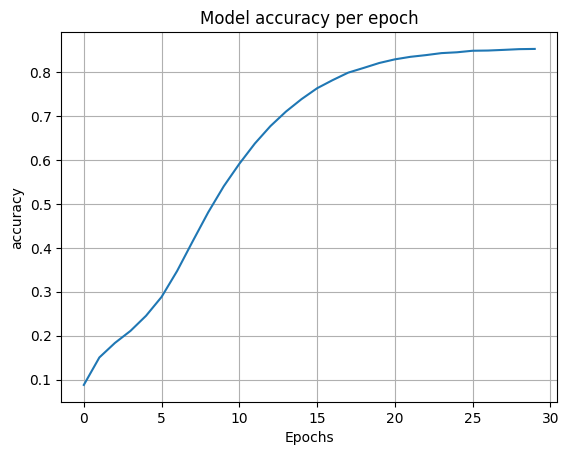

In [38]:
graph(model,'accuracy')

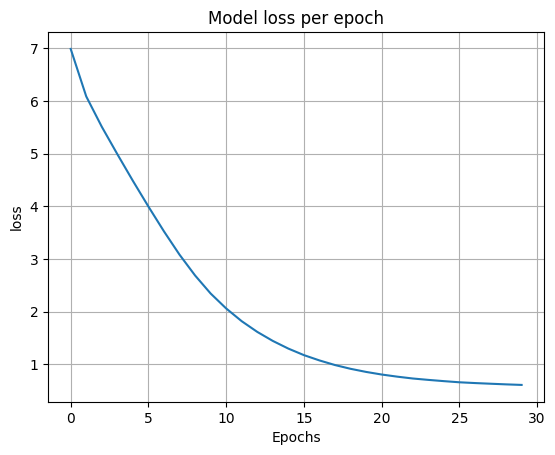

In [39]:
graph(model,'loss')

## GRU Neural Network 

**1. Similar to LSTM models, GRU models also make use of gated units (hence the name!) that control what information should be stored in memory and what should be forgotten. Unlike LSTM models, however, GRUs only have two gates: reset and update.Here is a diagram of what a GRU looks like:**

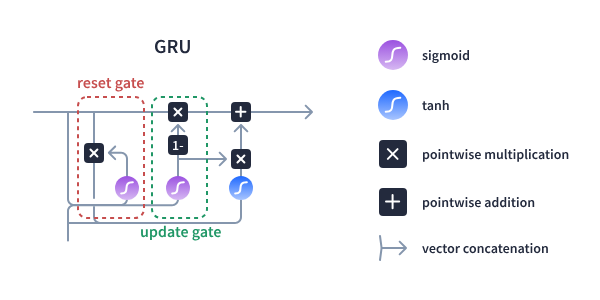

## GRU Neural Network Model Training

In [40]:
model2 = Sequential()
model2.add(Embedding(8237,300,input_length = 39))
model2.add(GRU(150))
model2.add(Dense(8237,activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 300)           2471100   
                                                                 
 gru (GRU)                   (None, 150)               203400    
                                                                 
 dense_1 (Dense)             (None, 8237)              1243787   
                                                                 
Total params: 3918287 (14.95 MB)
Trainable params: 3918287 (14.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
history = model2.fit(X,y,epochs = 30)

Epoch 1/30
1515/1515 [==============================] - 28s 17ms/step - loss: 6.9182 - accuracy: 0.0929
Epoch 2/30
1515/1515 [==============================] - 17s 11ms/step - loss: 5.8897 - accuracy: 0.1657
Epoch 3/30
1515/1515 [==============================] - 17s 11ms/step - loss: 5.2394 - accuracy: 0.2022
Epoch 4/30
1515/1515 [==============================] - 17s 11ms/step - loss: 4.5848 - accuracy: 0.2405
Epoch 5/30
1515/1515 [==============================] - 17s 11ms/step - loss: 3.9331 - accuracy: 0.2995
Epoch 6/30
1515/1515 [==============================] - 17s 11ms/step - loss: 3.3258 - accuracy: 0.3822
Epoch 7/30
1515/1515 [==============================] - 16s 11ms/step - loss: 2.7834 - accuracy: 0.4691
Epoch 8/30
1515/1515 [==============================] - 16s 11ms/step - loss: 2.3302 - accuracy: 0.5488
Epoch 9/30
1515/1515 [==============================] - 17s 11ms/step - loss: 1.9645 - accuracy: 0.6151
Epoch 10/30
1515/1515 [==============================] - 16s 11m

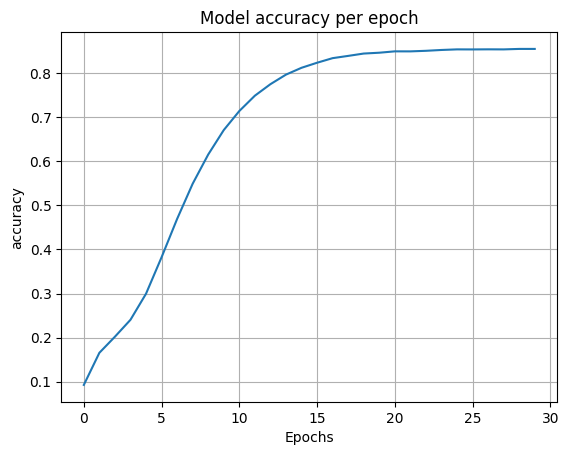

In [42]:
graph(model2,'accuracy')

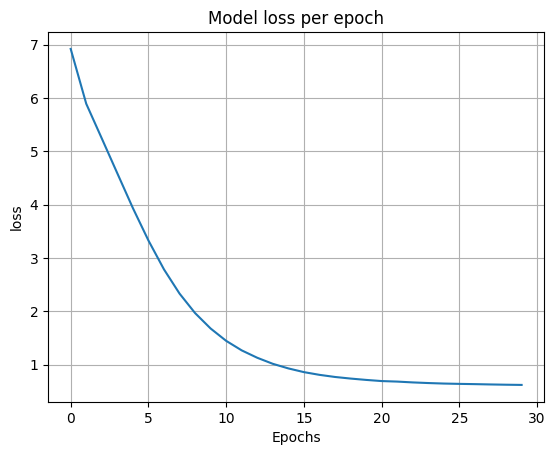

In [43]:
graph(model2,'loss')

## Evaluating LSTM model on unseen data

In [44]:
import time
text = 'Implementation '

for i in range(6):
    token_text = tokenizer.texts_to_sequences([text])[0]
    padded_token_text = pad_sequences([token_text],maxlen = 39,padding = 'pre')
    pos = np.argmax(model.predict(padded_token_text))

    for word,index in tokenizer.word_index.items():
        if index == pos:
            text = text + ' ' + word
            print(text)
            time.sleep(2)

1/1 [==============================] - 0s 371ms/step
Implementation  of
1/1 [==============================] - 0s 22ms/step
Implementation  of rnn
1/1 [==============================] - 0s 24ms/step
Implementation  of rnn lstm
1/1 [==============================] - 0s 20ms/step
Implementation  of rnn lstm and
1/1 [==============================] - 0s 19ms/step
Implementation  of rnn lstm and gru
1/1 [==============================] - 0s 28ms/step
Implementation  of rnn lstm and gru instance


## Evaluating GRU model on unseen data

In [45]:
import time
text = 'Implementation '

for i in range(6):
    token_text = tokenizer.texts_to_sequences([text])[0]
    padded_token_text = pad_sequences([token_text],maxlen = 39,padding = 'pre')
    pos = np.argmax(model2.predict(padded_token_text))

    for word,index in tokenizer.word_index.items():
        if index == pos:
            text = text + ' ' + word
            print(text)
            time.sleep(2)

1/1 [==============================] - 1s 1s/step
Implementation  of
1/1 [==============================] - 0s 18ms/step
Implementation  of rnn
1/1 [==============================] - 0s 18ms/step
Implementation  of rnn lstm
1/1 [==============================] - 0s 18ms/step
Implementation  of rnn lstm and
1/1 [==============================] - 0s 26ms/step
Implementation  of rnn lstm and gru
1/1 [==============================] - 0s 18ms/step
Implementation  of rnn lstm and gru optimization


## Conclusion :

**1. Performance wise both GRU and LSTM is giving accuracy of 86% after 30 epochs.But In our case GRU is performing slightly better than LSTM.**

**2. The reason behind to choose GRU is that our dataset  is samll and GRU is best suitable for smaller dataset and GRUs have a simpler architecture (fewer gates) than LSTM, they use less memory and tend to run faster.**